In [1]:
!python -m spacy download fr_core_news_sm

2024-01-22 11:44:31.833028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 11:44:31.833100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 11:44:31.835431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 11:44:31.845372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 11:44:33.799239: W tensorflow/compiler/tf2

In [7]:
import spacy
import pandas as pd
from transformers import BertTokenizer, BertModel
from concurrent.futures import TimeoutError
import multiprocessing as mp

# Load spaCy models
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# Load BERT tokenizer and model for Arabic
tokenizer = BertTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")
model = BertModel.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")

# Define a custom spaCy pipeline component using BERT embeddings
@spacy.Language.component("custom_bert")
def custom_bert_component(doc):
    text = doc.text
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)  # Adjust max_length as needed
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    doc.set_extension("bert_embeddings", default=embeddings, force=True)
    return doc

# Add the custom component to the spaCy pipeline for Darija
nlp_darija = spacy.blank("ar")
nlp_darija.add_pipe("custom_bert", last=True)

# Load your dataset from a CSV file
df = pd.read_csv("songs _data.csv")  # Replace with the actual path to your dataset

# Process lyrics in each language with a timeout
timeout_seconds = 10  # You can adjust the timeout as needed

def process_text(text):
    try:
        return nlp_fr(text) if nlp_fr(text).lang_ == 'fr' else nlp_en(text) if nlp_en(text).lang_ == 'en' else nlp_darija(text)
    except TimeoutError:
        return None

# Use multiprocessing to apply the function with a timeout
with mp.Pool() as pool:
    df['doc'] = pool.map(process_text, df['Lyrics'])

# Access BERT embeddings for each language
df['bert_embeddings'] = df['doc'].apply(lambda x: x._.bert_embeddings if hasattr(x._, 'bert_embeddings') else None)

# Display the processed DataFrame
print(df)


                                                Lyrics  Dialect  \
0        شدة و تزول عادي و يصير عادي بلي نطيح نعلّي...        1   
1      بايع و شاري رابح في خطاري مركيت نهاري تعرف ا...        1   
2     والله دنيا صعيبة زيد الناس غريبة ‎نعيشو في تر...        1   
3         دنيا تحب الكاش كيما الانثى تحب الرانج نحك...        1   
4      تزعز خاطري في نص الليل روحت شوار اللي بيا اس...        1   
..                                                 ...      ...   
987  هلا هلا هلالمغاربة سبوعة ورجالةديرو ديرو النية...        0   
988  ارحمني من عينيك، شوف فيا بالقدر الكافيأنا.مزاو...        0   
989  لالة فاطمة لالة فاطمةلالة فاطمة عار ربي غير كل...        0   
990  سالبة سالبة ها سلباني يا بنت ميوخاطري هاني ولا...        0   
991  الحباب غابو و مشاو و خلاو دموع قويةمن يوم فارق...        0   

                  Artist                  Song  \
0                    NaN                   NaN   
1                    NaN                   NaN   
2                    NaN                   Na

linguistic features

In [71]:
import pandas as pd
import spacy
from transformers import BertTokenizer, BertModel
from concurrent.futures import TimeoutError
import multiprocessing as mp

# Load spaCy models
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# Load BERT tokenizer and model for Arabic
tokenizer = BertTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")
model = BertModel.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-msa")

# Define a custom spaCy pipeline component using BERT embeddings
@spacy.Language.component("custom_bert")
def custom_bert_component(doc):
    text = doc.text
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)  # Adjust max_length as needed
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    doc.set_extension("bert_embeddings", default=embeddings, force=True)
    return doc

# Add the custom component to the spaCy pipeline for Darija
nlp_darija = spacy.blank("ar")
nlp_darija.add_pipe("custom_bert", last=True)

# Function to extract linguistic features
def extract_linguistic_features(doc):
    # Extract part-of-speech (POS) tags
    pos_tags = [token.pos_ for token in doc]

    # Extract named entities
    entities = [ent.text for ent in doc.ents]

    return {
        'POS_tags': pos_tags,
        'named_entities': entities,
    }

# Load your dataset from a CSV file
df = pd.read_csv("songs _data.csv")  # Replace with the actual path to your dataset

# Process lyrics in each language with a timeout
timeout_seconds = 10  # You can adjust the timeout as needed

def process_text(text):
    try:
        return nlp_fr(text) if nlp_fr(text).lang_ == 'fr' else nlp_en(text) if nlp_en(text).lang_ == 'en' else nlp_darija(text)
    except TimeoutError:
        return None

# Use multiprocessing to apply the function with a timeout
with mp.Pool() as pool:
    df['doc'] = pool.map(process_text, df['Lyrics'])

# Extract linguistic features for each language
df['linguistic_features'] = df['doc'].apply(lambda x: extract_linguistic_features(x) if x is not None else None)

# Sauvegarder le DataFrame dans un fichier CSV
df.to_csv('result.csv', index=False)

# Display the processed DataFrame
print(df)

                                                Lyrics  Dialect  \
0        شدة و تزول عادي و يصير عادي بلي نطيح نعلّي...        1   
1      بايع و شاري رابح في خطاري مركيت نهاري تعرف ا...        1   
2     والله دنيا صعيبة زيد الناس غريبة ‎نعيشو في تر...        1   
3         دنيا تحب الكاش كيما الانثى تحب الرانج نحك...        1   
4      تزعز خاطري في نص الليل روحت شوار اللي بيا اس...        1   
..                                                 ...      ...   
987  هلا هلا هلالمغاربة سبوعة ورجالةديرو ديرو النية...        0   
988  ارحمني من عينيك، شوف فيا بالقدر الكافيأنا.مزاو...        0   
989  لالة فاطمة لالة فاطمةلالة فاطمة عار ربي غير كل...        0   
990  سالبة سالبة ها سلباني يا بنت ميوخاطري هاني ولا...        0   
991  الحباب غابو و مشاو و خلاو دموع قويةمن يوم فارق...        0   

                  Artist                  Song  \
0                    NaN                   NaN   
1                    NaN                   NaN   
2                    NaN                   Na

Similarité entre les chansons

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Créez une matrice de similarité vide
similarity_matrix = []

# Parcourez toutes les paires de chansons
for i in range(len(df)):
    similarities = []
    for j in range(len(df)):
        # Mesurez la similarité cosinus entre les embeddings BERT des deux chansons
        similarity = cosine_similarity([df['bert_embeddings'][i]], [df['bert_embeddings'][j]])[0][0]

        # Ajoutez une pondération pour la dialecte (1 si même dialecte, 0 sinon)
        dialect_weight = 1 if df['Dialect'][i] == df['Dialect'][j] else 0
        weighted_similarity = similarity * dialect_weight
        similarities.append(weighted_similarity)

    similarity_matrix.append(similarities)

# Convertissez la matrice de similarité en DataFrame pour une meilleure lisibilité
similarity_df = pd.DataFrame(similarity_matrix, columns=df.index, index=df.index)

# Affichez la matrice de similarité
print(similarity_df)


     0    1    2    3    4    5    6    7    8    9    ...  982  983  984  \
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
987  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0   
988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0   
989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0   
990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0   
991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  1.0   

     985  986  987  988  989  990  991  
0    0.0  0.0  0.0  0.0  0.0  0.0 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


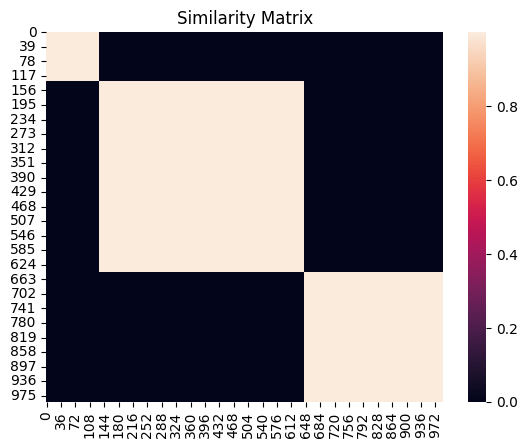

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
Cluster 2: [131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

In [11]:
# Appliquez K-means sur la matrice de similarité
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
num_clusters = 3  # Choisissez le nombre de clusters en fonction de votre analyse
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Dialect'] = kmeans.fit_predict(similarity_matrix)

# Visualisez les clusters
sns.heatmap(similarity_matrix)
plt.title('Similarity Matrix')
plt.show()

# Affichez les chansons dans chaque cluster
for cluster_id in range(num_clusters):
    cluster_songs = df[df['Dialect'] == cluster_id].index.tolist()
    print(f'Cluster {cluster_id + 1}: {cluster_songs}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


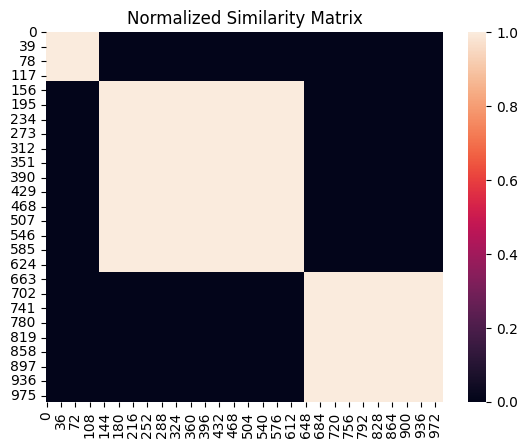

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
Cluster 2: [131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Normalisez la matrice de similarité
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix)

# Appliquez K-means sur la matrice de similarité normalisée
num_clusters = 3  # Choisissez le nombre de clusters en fonction de votre analyse
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Dialect'] = kmeans.fit_predict(normalized_similarity_matrix)

# Visualisez les clusters
sns.heatmap(normalized_similarity_matrix)
plt.title('Normalized Similarity Matrix')
plt.show()

# Affichez les chansons dans chaque cluster
for cluster_id in range(num_clusters):
    cluster_songs = df[df['Dialect'] == cluster_id].index.tolist()
    print(f'Cluster {cluster_id + 1}: {cluster_songs}')


In [49]:
# Remplacez 'chanson_reference' par l'index de la chanson de référence que vous souhaitez
chanson_reference = 12

# Extrait la ligne de similarité pour la chanson de référence
similarities_to_chanson_reference = similarity_df.iloc[chanson_reference]

# Définissez un seuil de similarité (ajustez ce seuil en fonction de vos besoins)
similarity_threshold = 0.8

# Filtrez les indices des chansons similaires en fonction du seuil
similar_chansons_indices = similarities_to_chanson_reference[similarities_to_chanson_reference > similarity_threshold].index

# Choisissez aléatoirement 5 chansons parmi les chansons similaires
random_5_chansons_indices = random.sample([idx for idx in similar_chansons_indices if idx != chanson_reference], min(5, len(similar_chansons_indices)))

# Affiche les paroles des 5 chansons similaires choisies aléatoirement
print(f"Paroles des 5 chansons similaires à la chanson {chanson_reference} (choisies aléatoirement) :")
for i, chanson_index in enumerate(random_5_chansons_indices):
    chanson_lyrics = df['Lyrics'][chanson_index]
    print(f"{i+1}. Chanson {chanson_index} - Paroles :")
    print(chanson_lyrics)
    print("\n" + "-"*50 + "\n")  # Ajoute une ligne pour séparer les paroles des chansons


Paroles des 5 chansons similaires à la chanson 12 (choisies aléatoirement) :
1. Chanson 45 - Paroles :
   نعرف اللي تخمم باش تمشي نعرف اللي صعيبة اما طامع باش تحسن احوال كل ما ترانا في لما تولي ساق لتالي وساق لقدام كل ما تقدم خطوة تكسر باب وتتسكر بيبان حاب تحقق احلام حاب الدنيا تزيان امي تحبك ديما قريب باش تحس ان العالم مزيان قلبك يحب أما مخك اللي ما عادش ينجم يرفع كلام ماشي لبرا مش الجنة لازم تفهم أنا خوفي مازال مشيتو الكل اش مازال  وما كانش عندي مشكل اللي انا نعيش من اولي انا لنا نحب نعيش وين الناس اللي نحبها ديما قرابلي والله ما غزرتش لبارا مرة مانيش نرا فصحابي حتى اللي قراو معايا غادين ولاو يراو كان فلنا مدارا جوابي موش سكات كي كل مرة حتى أنا تعبوني واللي سمعتو أكثر ملي ريتو أنا نحب نعيش الحلمة كانوني قلبي مكسر نتفكر نتحسر نعطي الثيقة نلقا منهم كان دوني مشينا بأصل ما مشاوش بالأصل حتى كان في الخير الشر رماوهولي اللي يحبو سمعوني  وموش حنى لي ختارنا نعيشو ونموتو في شرنا الحمد لله بلي فيه عايشين لنا حتى بلاش بقدرنا فاما عيلة تسمع همنا تحس اللي فما غالين نعرف اللي بزايد صبرنا حلمنا في ك

common themes

In [52]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Supposons que 'dialect' dans votre DataFrame représente le pays attribué par K-means
# df est votre DataFrame qui doit contenir une colonne 'lyrics' avec les paroles et une colonne 'dialect' avec les identifiants de pays

# Fonction fictive pour identifier les thèmes communs dans les paroles
def identify_common_themes(lyrics):
    # Utilisez CountVectorizer pour extraire des mots clés des paroles
    vectorizer = CountVectorizer(stop_words='english', max_features=5)
    X = vectorizer.fit_transform(lyrics)
    feature_names = vectorizer.get_feature_names_out()

    # Trouvez les mots clés les plus fréquents
    common_themes = [feature_names[i] for i in X.sum(axis=0).argsort()[0, ::-1]]

    return common_themes

# Affichez les thèmes communs pour chaque pays (dialect)
for country_id in df['Dialect'].unique():
    country_songs = df[df['Dialect'] == country_id]

    # Affichez les thèmes communs pour le pays (dialect)
    common_themes = identify_common_themes(country_songs['Lyrics'])

    print(f'Thèmes communs pour le pays (dialect) {country_id+1}: {common_themes}')


Thèmes communs pour le pays (dialect) 1: [array([['في', 'ما', 'اللي', 'لا', 'كان']], dtype=object)]
Thèmes communs pour le pays (dialect) 2: [array([['la', 'est', 'le', 'les', 'pas']], dtype=object)]
Thèmes communs pour le pays (dialect) 3: [array([['la', 'ma', 'li', 'ya', 'est']], dtype=object)]


In [54]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Supposons que 'dialect' dans votre DataFrame représente le pays attribué par K-means
# df est votre DataFrame qui doit contenir une colonne 'Lyrics' avec les paroles et une colonne 'Dialect' avec les identifiants de pays

# Fonction pour extraire les idées communes dans les paroles en utilisant LDA
def extract_common_ideas(lyrics):
    # Utilisez CountVectorizer pour créer une matrice de termes
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(lyrics)

    # Appliquez le modèle LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(X)

    # Affichez les mots clés pour chaque "thème" identifié par LDA
    feature_names = vectorizer.get_feature_names_out()
    common_ideas = []
    for topic_idx, topic in enumerate(lda.components_):
        top_keywords_idx = topic.argsort()[:-6:-1]
        top_keywords = [feature_names[i] for i in top_keywords_idx]
        common_ideas.append(top_keywords)

    return common_ideas

# Affichez les idées communes pour chaque pays (dialect)
for country_id in df['Dialect'].unique():
    country_songs = df[df['Dialect'] == country_id]

    # Obtenez les paroles de chansons pour le pays (dialect)
    lyrics = country_songs['Lyrics'].tolist()

    # Affichez les idées communes pour le pays (dialect)
    common_ideas = extract_common_ideas(lyrics)

    print(f'Idées communes pour le pays (dialect) {country_id+1}: {common_ideas}')


Idées communes pour le pays (dialect) 1: [['fi', 'li', 'ma', 'ya', 'ah'], ['diga', 'el', 'la', 'oh', 'le'], ['في', 'لا', 'اللي', 'ما', 'يا'], ['في', 'ما', 'من', 'كان', 'اللي'], ['في', 'موش', 'ما', 'ساهل', 'نستاهل']]
Idées communes pour le pays (dialect) 2: [['ma', 'ya', 'ha', 'ah', 'ki'], ['solo', 'le', 'est', 'elle', 'va'], ['ya', 'ou', 'ma', 'ana', 'el'], ['wili', 'je', 'nuit', 'ya', 'ma'], ['est', 'les', 'le', 'pas', 'dans']]
Idées communes pour le pays (dialect) 3: [['يا', 'لي', 'ما', 'من', 'في'], ['li', 'wah', 'wa', 'ya', 'ma'], ['la', 'ma', 'li', 'men', 'gha'], ['ya', 'la', 'ou', 'ana', 'lala'], ['la', 'est', 'pas', 'le', 'je']]


Sentiments

In [58]:
!pip install textblob


                                                Lyrics     sentiment
0        شدة و تزول عادي و يصير عادي بلي نطيح نعلّي...  0.000000e+00
1      بايع و شاري رابح في خطاري مركيت نهاري تعرف ا... -1.200000e-01
2     والله دنيا صعيبة زيد الناس غريبة ‎نعيشو في تر...  4.625929e-17
3         دنيا تحب الكاش كيما الانثى تحب الرانج نحك...  1.888889e-01
4      تزعز خاطري في نص الليل روحت شوار اللي بيا اس... -2.333333e-01
..                                                 ...           ...
987  هلا هلا هلالمغاربة سبوعة ورجالةديرو ديرو النية...  0.000000e+00
988  ارحمني من عينيك، شوف فيا بالقدر الكافيأنا.مزاو...  0.000000e+00
989  لالة فاطمة لالة فاطمةلالة فاطمة عار ربي غير كل...  0.000000e+00
990  سالبة سالبة ها سلباني يا بنت ميوخاطري هاني ولا...  0.000000e+00
991  الحباب غابو و مشاو و خلاو دموع قويةمن يوم فارق...  0.000000e+00

[992 rows x 2 columns]


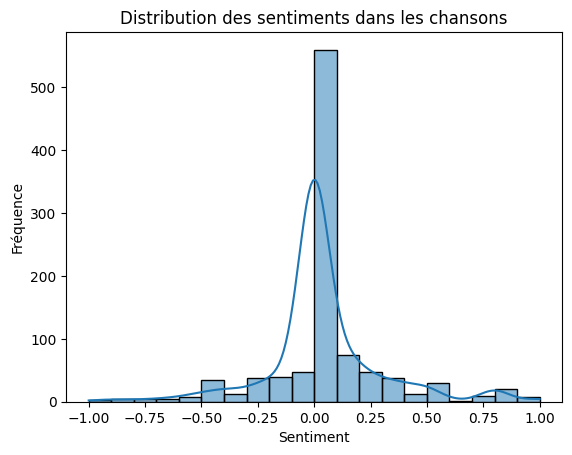

In [ ]:
from textblob import TextBlob

# Ajoutez une nouvelle colonne 'sentiment' à votre DataFrame
df['sentiment'] = df['Lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Affichez les sentiments pour chaque chanson
print(df[['Lyrics', 'sentiment']])

# Visualisez les sentiments communs
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Distribution des sentiments dans les chansons')
plt.xlabel('Sentiment')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
!pip install nltk


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                Lyrics  sentiment
0        شدة و تزول عادي و يصير عادي بلي نطيح نعلّي...     0.0000
1      بايع و شاري رابح في خطاري مركيت نهاري تعرف ا...     0.6249
2     والله دنيا صعيبة زيد الناس غريبة ‎نعيشو في تر...     0.9231
3         دنيا تحب الكاش كيما الانثى تحب الرانج نحك...     0.6908
4      تزعز خاطري في نص الليل روحت شوار اللي بيا اس...    -0.5267
..                                                 ...        ...
987  هلا هلا هلالمغاربة سبوعة ورجالةديرو ديرو النية...     0.0000
988  ارحمني من عينيك، شوف فيا بالقدر الكافيأنا.مزاو...     0.0000
989  لالة فاطمة لالة فاطمةلالة فاطمة عار ربي غير كل...     0.0000
990  سالبة سالبة ها سلباني يا بنت ميوخاطري هاني ولا...     0.0000
991  الحباب غابو و مشاو و خلاو دموع قويةمن يوم فارق...     0.0000

[992 rows x 2 columns]


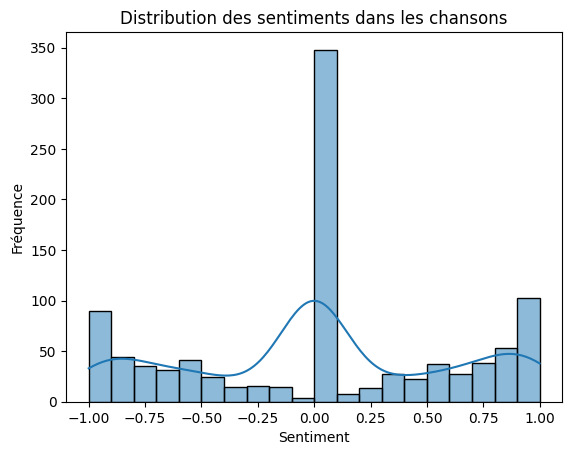

In [ ]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Téléchargez les ressources nécessaires pour nltk
nltk.download('vader_lexicon')

# Initialisez l'analyseur de sentiment
sia = SentimentIntensityAnalyzer()

# Chargez votre DataFrame à partir du fichier CSV (à remplacer par le chemin réel)
df = pd.read_csv("songs _data.csv")

# Ajoutez une nouvelle colonne 'sentiment' à votre DataFrame
df['sentiment'] = df['Lyrics'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Affichez les sentiments pour chaque chanson
print(df[['Lyrics', 'sentiment']])

# Visualisez les sentiments communs
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Distribution des sentiments dans les chansons')
plt.xlabel('Sentiment')
plt.ylabel('Fréquence')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Load your dataset
df = pd.read_csv('songs _data.csv')

# Preprocess the lyrics
stop_words = set(stopwords.words('english'))  # Add other languages as needed
stemmer = SnowballStemmer('english')  # Use appropriate stemmer for other languages

def preprocess_text(text):
    words = text.lower().split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['processed_lyrics'] = df['Lyrics'].apply(preprocess_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_lyrics'])

# Apply K-means clustering
num_clusters = 3  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Explore the clusters
for cluster_id in range(num_clusters):
    cluster_songs = df[df['cluster'] == cluster_id]['lyrics'].tolist()
    print(f'Cluster {cluster_id + 1} Songs:')
    for song in cluster_songs:
        print(song)
    print('\n')


In [56]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00


In [57]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Supposons que 'dialect' dans votre DataFrame représente le pays attribué par K-means
# df est votre DataFrame qui doit contenir une colonne 'Lyrics' avec les paroles et une colonne 'Dialect' avec les identifiants de pays

# Fonction pour extraire les sentiments communs dans les paroles en utilisant VADER
def extract_common_sentiments(lyrics):
    analyzer = SentimentIntensityAnalyzer()
    sentiments = [analyzer.polarity_scores(lyric)['compound'] for lyric in lyrics]

    return sentiments

# Affichez les sentiments communs pour chaque pays (dialect)
for country_id in df['Dialect'].unique():
    country_songs = df[df['Dialect'] == country_id]

    # Obtenez les paroles de chansons pour le pays (dialect)
    lyrics = country_songs['Lyrics'].tolist()

    # Affichez les sentiments communs pour le pays (dialect)
    common_sentiments = extract_common_sentiments(lyrics)

    print(f'Sentiments communs pour le pays (dialect) {country_id+1}: {common_sentiments}')


Sentiments communs pour le pays (dialect) 1: [0.0, 0.7964, 0.9231, 0.6908, -0.5267, 0.9047, -0.5267, 0.0, 0.0772, -0.5719, -0.5423, -0.5574, 0.0, -0.5267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.743, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5994, 0.0, 0.0, 0.296, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5267, 0.9047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9994, 0.0, 0.9719, 0.9801, -0.2023, 0.811, -0.5759, 0.0, -0.5267, -0.9713, 0.4939, 0.7096, 0.0, 0.0, -0.8896, -0.9917, 0.0, 0.0, 0.0, 0.0, 0.0, 0.296, 0.4939, 0.0, 0.0, 0.7964, -0.5267, 0.9047, 0.0, 0.8114, 0.0, 0.0, -0.872, -0.296, 0.0, 0.0, 0.9801, 0.0, 0.8117, 0.0, 0.0, 0.0, 0.0, -0.7783, 0.0, 0.0, 0.0, 0.0, -0.9757, 0.8114, 0.8934, -0.4767, 0.0, 0.0, 0.0, 0.0, 0.9903, 0.8117, -0.7081, -0.7212, 0.0, 0.0, 0.9801, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8689, 0.9868, 0.0, 0.9923, -0.9875, 0.9719, 0.0, 0.0, -0.7212]
Sentiments communs pour le pays (dialect) 2: [0.0, 0.982, -0.6369, 0.9878, 0.5859, -0.9186, 0.1531, 0.0, 0.9451, 0.0, 0.

In [59]:
from textblob import TextBlob

# Fonction pour extraire le sentiment dominant dans les paroles en utilisant TextBlob
def extract_dominant_sentiment(lyrics):
    sentiments = [TextBlob(lyric).sentiment.polarity for lyric in lyrics]

    # Convertir les valeurs de polarité en catégories de sentiment
    sentiment_categories = ['joie' if sentiment > 0 else 'tristesse' if sentiment < 0 else 'neutre' for sentiment in sentiments]

    # Trouver le sentiment dominant
    dominant_sentiment = max(set(sentiment_categories), key=sentiment_categories.count)

    return dominant_sentiment

# Affichez le sentiment dominant pour chaque pays (dialect)
for country_id in df['Dialect'].unique():
    country_songs = df[df['Dialect'] == country_id]

    # Obtenez les paroles de chansons pour le pays (dialect)
    lyrics = country_songs['Lyrics'].tolist()

    # Affichez le sentiment dominant pour le pays (dialect)
    dominant_sentiment = extract_dominant_sentiment(lyrics)

    print(f'Sentiment dominant pour le pays (dialect) {country_id+1}: {dominant_sentiment}')


Sentiment dominant pour le pays (dialect) 1: neutre
Sentiment dominant pour le pays (dialect) 2: joie
Sentiment dominant pour le pays (dialect) 3: neutre


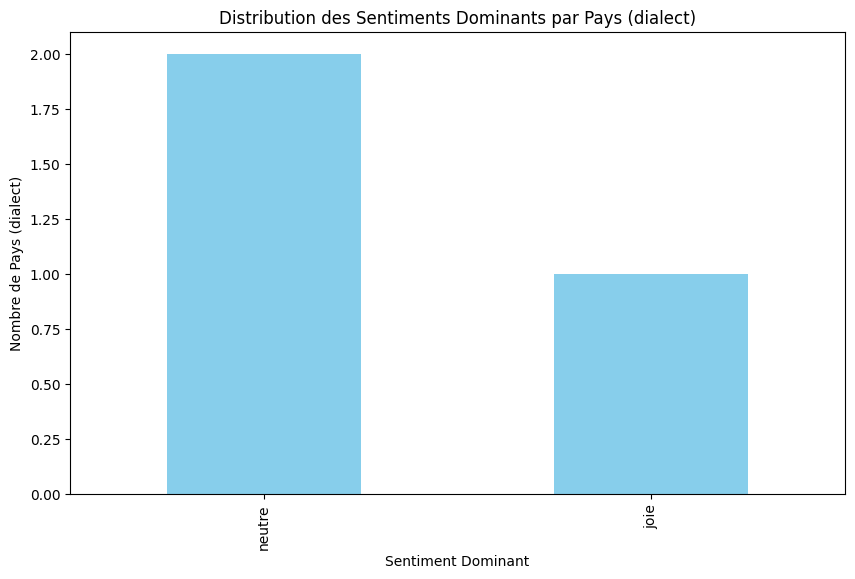

In [60]:
import matplotlib.pyplot as plt

# Stockez les résultats dans un dictionnaire
dominant_sentiments_dict = {}

# Collectez les sentiments dominants pour chaque pays (dialect)
for country_id in df['Dialect'].unique():
    country_songs = df[df['Dialect'] == country_id]

    # Obtenez les paroles de chansons pour le pays (dialect)
    lyrics = country_songs['Lyrics'].tolist()

    # Obtenez le sentiment dominant pour le pays (dialect)
    dominant_sentiment = extract_dominant_sentiment(lyrics)

    # Stockez le résultat dans le dictionnaire
    dominant_sentiments_dict[country_id+1] = dominant_sentiment

# Convertissez le dictionnaire en DataFrame pour une visualisation plus facile
result_df = pd.DataFrame(list(dominant_sentiments_dict.items()), columns=['Pays (dialect)', 'Sentiment Dominant'])

# Créez un diagramme à barres pour visualiser les sentiments dominants
plt.figure(figsize=(10, 6))
result_df['Sentiment Dominant'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution des Sentiments Dominants par Pays (dialect)')
plt.xlabel('Sentiment Dominant')
plt.ylabel('Nombre de Pays (dialect)')
plt.show()


In [61]:
!pip install nltk
!pip install scikit-learn

In [63]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [67]:
import nltk

# Download NLTK punkt (if not already downloaded)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [68]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords (if not already downloaded)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Supposons que 'dialect' dans votre DataFrame représente le pays attribué par K-means
# df est votre DataFrame qui doit contenir une colonne 'Lyrics' avec les paroles et une colonne 'Dialect' avec les identifiants de pays

# Fonction pour extraire des expressions culturelles
def extract_cultural_expressions(lyrics, language):
    stop_words = set(stopwords.words(language))

    # Tokenisation des paroles
    tokens = [word_tokenize(lyric.lower()) for lyric in lyrics]

    # Retirer les mots vides
    filtered_tokens = [[word for word in token if word.isalnum() and word not in stop_words] for token in tokens]

    # Concaténer les mots pour chaque chanson
    preprocessed_lyrics = [' '.join(filtered_token) for filtered_token in filtered_tokens]

    # Utiliser TF-IDF pour extraire des expressions culturelles
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_lyrics)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Trouver les mots les plus importants par chanson
    top_words_per_song = [", ".join([feature_names[idx] for idx in doc.nonzero()[1]]) for doc in tfidf_matrix]

    return top_words_per_song

# Affichez les expressions culturelles pour chaque pays (dialect)
for country_id in df['Dialect'].unique():
    country_songs = df[df['Dialect'] == country_id]

    # Obtenez les paroles de chansons pour le pays (dialect)
    lyrics = country_songs['Lyrics'].tolist()

    # Affichez les expressions culturelles pour le pays (dialect)
    cultural_expressions = extract_cultural_expressions(lyrics, language='french')  # Remplacez 'french' par votre langue
    print(f'Expressions culturelles pour le pays (dialect) {country_id+1}: {cultural_expressions}')


Expressions culturelles pour le pays (dialect) 1: ['دوسي, أكحل, أكبر, زروصي, شطر, خسرت, نخمم, الليل, نبات, دروسي, مليح, قاري, خايض, حرب, ناموسي, عندي, أما, رايض, معاهم, نعيش, المال, نجيبو, بلاش, حلال, بنت, معايا, باهي, قلبي, الهبال, في, كتيبة, نعيشو, باقي, رجال, تربينا, بخوت, الدنيا, كان, بكيناش, لما, يفوت, الوقت, للعالي, دعينا, اللي, نحنا, علاش, كبير, عالي, شارع, الموت, من, أحنا, شكيت, إنتي, لغيرك, يمة, الباهي, كنت, وليت, دوني, نجافيهم, نصافي, كي, ماني, نتيري, فيهم, تجي, شاري, انا, يبيعو, لينا, يكيدو, علينا, ذيوبة, بلاني, وقت, صغير, الدمعة, تنزل, نبكي, قدامك, خايف, لساني, يطاوقني, نحكيلك, قد, خاتر, سكاتي, كثر, زاد, كلامي, قليل, والله, يلا, يا, نلوم, عليها, بلادي, نهني, نكون, مصيري, نولي, ما, يدوم, حال, لا, نطيح, بلي, يصير, عادي, تزول, شدة', 'اللقطة, نعاودش, الفيلم, نعاود, لمعقدة, بالمخاخ, وعبثنا, الكرز, خلصنا, مرقدة, ذهب, مخاخ, أفكار, رواحنا, investina, مبقطة, العباد, غدار, تعرفني, ماك, ليسار, بار, حتي, نلقي, كيما, القطار, السكة, العار, عملنا, لي, موش, للمطار, الطبعة, زك, صغار, ريناه,